In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
from timm import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import cv2

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
 'train': transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
 'val': transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
}


batch_size = 4
data_dir = './datasets/100sportClassification'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
 shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
        ax.set_axis_off()


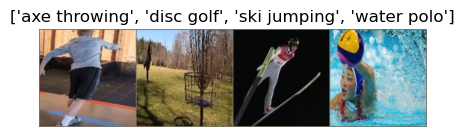

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
def set_parameter_requires_grad(model, feature_extracting=False):
    if feature_extracting:
    # frozen model
        model.requires_grad_(False)
    else:
    # fine-tuning
        model.requires_grad_(True)


In [6]:
#!git clone https://github.com/hila-chefer/Transformer-Explainability.git
#!pip install einops
os.chdir(f'./Transformer-Explainability')

import baselines.ViT.ViT_new
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

In [8]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 224 # image size, e.g. (3, 224, 224)
    model_ft=vit_LRP(pretrained=True).cuda()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.head.in_features
    model_ft.head = nn.Linear(num_ftrs, num_classes)  # Replace the head for classification

    return model_ft, input_size


In [9]:
os.chdir(f'..')

In [10]:
#hyperparameters
num_classes = 100
batch_size = 8
num_epochs = 5
# Flag for feature extracting. When False, we fine-tune the whole model.
feature_extract = True


In [11]:
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
# Print the model
print(model_ft)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=100, bia

In [12]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = [] # override the initial list definition above
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 head.weight
	 head.bias


In [13]:
"""
Training function
"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
# Setup the loss fuction, and train the model
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


train Loss: 0.8681 Acc: 0.8001
val Loss: 0.1657 Acc: 0.9460

Epoch 1/4
----------
train Loss: 0.4538 Acc: 0.8808
val Loss: 0.1432 Acc: 0.9600

Epoch 2/4
----------
train Loss: 0.3805 Acc: 0.8956
val Loss: 0.1298 Acc: 0.9700

Epoch 3/4
----------
train Loss: 0.3563 Acc: 0.9037
val Loss: 0.1205 Acc: 0.9600

Epoch 4/4
----------
train Loss: 0.3369 Acc: 0.9066
val Loss: 0.1079 Acc: 0.9740

Training complete in 5m 49s
Best val Acc: 0.974000


In [14]:
#torch.save(model_ft.state_dict(), './vit_new_weights.pth')
model_ft.load_state_dict(torch.load('./vit_new_weights.pth'))

/tmp/ipykernel_871276/668826667.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('./vit_new_weights.pth'))


<All keys matched successfully>

In [15]:
os.chdir(f'./Transformer-Explainability')

In [16]:
CLS2IDX = {
    0: 'air hockey',
    1: 'ampute football',
    2: 'archery',
    3: 'arm wrestling',
    4: 'axe throwing',
    5: 'balance beam',
    6: 'barell racing',
    7: 'baseball',
    8: 'basketball',
    9: 'baton twirling',
    10: 'bike polo',
    11: 'billiards',
    12: 'bmx',
    13: 'bobsled',
    14: 'bowling',
    15: 'boxing',
    16: 'bull riding',
    17: 'bungee jumping',
    18: 'canoe slamon',
    19: 'cheerleading',
    20: 'chuckwagon racing',
    21: 'cricket',
    22: 'croquet',
    23: 'curling',
    24: 'disc golf',
    25: 'fencing',
    26: 'field hockey',
    27: 'figure skating men',
    28: 'figure skating pairs',
    29: 'figure skating women',
    30: 'fly fishing',
    31: 'football',
    32: 'formula 1 racing',
    33: 'frisbee',
    34: 'gaga',
    35: 'giant slalom',
    36: 'golf',
    37: 'hammer throw',
    38: 'hang gliding',
    39: 'harness racing',
    40: 'high jump',
    41: 'hockey',
    42: 'horse jumping',
    43: 'horse racing',
    44: 'horseshoe pitching',
    45: 'hurdles',
    46: 'hydroplane racing',
    47: 'ice climbing',
    48: 'ice yachting',
    49: 'jai alai',
    50: 'javelin',
    51: 'jousting',
    52: 'judo',
    53: 'lacrosse',
    54: 'log rolling',
    55: 'luge',
    56: 'motorcycle racing',
    57: 'mushing',
    58: 'nascar racing',
    59: 'olympic wrestling',
    60: 'parallel bar',
    61: 'pole climbing',
    62: 'pole dancing',
    63: 'pole vault',
    64: 'polo',
    65: 'pommel horse',
    66: 'rings',
    67: 'rock climbing',
    68: 'roller derby',
    69: 'rollerblade racing',
    70: 'rowing',
    71: 'rugby',
    72: 'sailboat racing',
    73: 'shot put',
    74: 'shuffleboard',
    75: 'sidecar racing',
    76: 'ski jumping',
    77: 'sky surfing',
    78: 'skydiving',
    79: 'snow boarding',
    80: 'snowmobile racing',
    81: 'speed skating',
    82: 'steer wrestling',
    83: 'sumo wrestling',
    84: 'surfing',
    85: 'swimming',
    86: 'table tennis',
    87: 'tennis',
    88: 'track bicycle',
    89: 'trapeze',
    90: 'tug of war',
    91: 'ultimate',
    92: 'uneven bars',
    93: 'volleyball',
    94: 'water cycling',
    95: 'water polo',
    96: 'weightlifting',
    97: 'wheelchair basketball',
    98: 'wheelchair racing',
    99: 'wingsuit flying'}

In [17]:
start_layer = 0

def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for i,blk in enumerate(model.blocks):
        if i < start_layer:
            continue
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

In [18]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(model, original_image, class_index=None):
    with torch.enable_grad():
        transformer_attribution = generate_relevance(model, original_image.unsqueeze(0).cuda(), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	8 : basketball           		value = 15.380	 prob = 98.9%
	97 : wheelchair basketball		value = 10.831	 prob = 1.0%
	59 : olympic wrestling    		value = 4.864	 prob = 0.0%
	71 : rugby                		value = 4.843	 prob = 0.0%
	73 : shot put             		value = 4.748	 prob = 0.0%


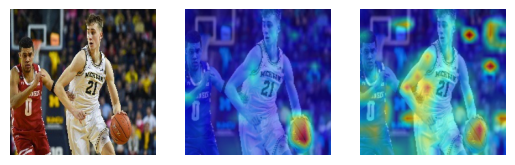

In [20]:
#swimming Vs basketball
model=model_ft
model.requires_grad_(True)
image = Image.open('../datasets/100sportClassification/val/basketball/1.jpg')
basketball_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(basketball_image.unsqueeze(0).cuda())
print_top_classes(output)

# basketball - the predicted class
basketball = generate_visualization(model,basketball_image)

# swimming 
# generate visualization for class 85: 'swimming'
swimming = generate_visualization(model,basketball_image, class_index=85)


axs[1].imshow(basketball);
axs[1].axis('off');
axs[2].imshow(swimming);
axs[2].axis('off');

Top 5 classes:
	85 : swimming          		value = 11.337	 prob = 89.3%
	95 : water polo        		value = 8.951	 prob = 8.2%
	94 : water cycling     		value = 7.549	 prob = 2.0%
	54 : log rolling       		value = 4.523	 prob = 0.1%
	69 : rollerblade racing		value = 4.036	 prob = 0.1%


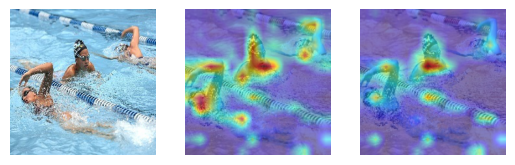

In [23]:
#swimming Vs basketball
image = Image.open('../datasets/100sportClassification/val/swimming/3.jpg')
swimming_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(swimming_image.unsqueeze(0).cuda())
print_top_classes(output)

# swimming - the predicted class
swimming = generate_visualization(model,swimming_image)

# basketball 
# generate visualization for class 8: 'basketball'
basketball = generate_visualization(model,swimming_image, class_index=8)


axs[1].imshow(swimming);
axs[1].axis('off');
axs[2].imshow(basketball);
axs[2].axis('off');

Top 5 classes:
	87 : tennis              		value = 11.958	 prob = 99.6%
	86 : table tennis        		value = 5.678	 prob = 0.2%
	36 : golf                		value = 3.702	 prob = 0.0%
	29 : figure skating women		value = 3.528	 prob = 0.0%
	26 : field hockey        		value = 3.354	 prob = 0.0%


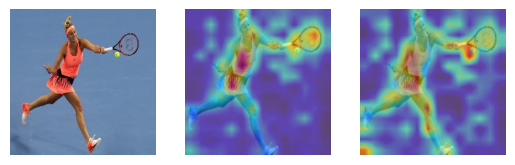

In [26]:
#tennis Vs boxing
image = Image.open('../datasets/100sportClassification/val/tennis/3.jpg')
tennis_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tennis_image.unsqueeze(0).cuda())
print_top_classes(output)

# tennis - the predicted class
tennis = generate_visualization(model,tennis_image)

# boxing 
# generate visualization for class 15: 'boxing'
boxing = generate_visualization(model,tennis_image, class_index=15)


axs[1].imshow(tennis);
axs[1].axis('off');
axs[2].imshow(boxing);
axs[2].axis('off');

Top 5 classes:
	15 : boxing        		value = 14.763	 prob = 100.0%
	73 : shot put      		value = 5.365	 prob = 0.0%
	3 : arm wrestling 		value = 4.558	 prob = 0.0%
	83 : sumo wrestling		value = 4.368	 prob = 0.0%
	55 : luge          		value = 3.651	 prob = 0.0%


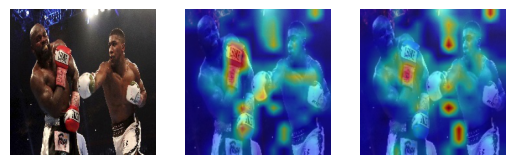

In [31]:
#tennis Vs boxing
image = Image.open('../datasets/100sportClassification/val/boxing/5.jpg')
boxing_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(boxing_image.unsqueeze(0).cuda())
print_top_classes(output)

# boxing - the predicted class
boxing = generate_visualization(model,boxing_image)

# tennis 
# generate visualization for class 87: 'tennis'
tennis = generate_visualization(model,boxing_image, class_index=87)


axs[1].imshow(boxing);
axs[1].axis('off');
axs[2].imshow(tennis);
axs[2].axis('off');